<a href="https://colab.research.google.com/github/AbhinavShakunt/MY_Data_Science_Notebooks/blob/main/Bert_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

ModuleNotFoundError: No module named 'tensorflow_text'

In [32]:
pip install tensorflow-text

In [33]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [34]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [35]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [36]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [37]:
747/4825

0.15481865284974095

In [38]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [39]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [40]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [41]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [42]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [43]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
2980,spam,"Xmas Offer! Latest Motorola, SonyEricsson & No...",1
1638,spam,"0A$NETWORKS allow companies to bill for SMS, s...",1
4991,spam,Phony £350 award - Todays Voda numbers ending ...,1
4429,ham,Aiyar dun disturb u liao... Thk u have lots 2 ...,0
1874,spam,You have WON a guaranteed £1000 cash or a £200...,1


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [45]:
X_train.head(4)

2420    SMS SERVICES For your inclusive text credits p...
352     If you're not in my car in an hour and a half ...
1846    Hi. || Do u want | to join me with sts later? ...
1636    You have come into my life and brought the sun...
Name: Message, dtype: object

In [46]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [47]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.51327264, -0.8884573 , ..., -0.7474888 ,
        -0.7531474 ,  0.91964495],
       [-0.8720834 , -0.5054395 , -0.94446665, ..., -0.85847485,
        -0.71745324,  0.88082963]], dtype=float32)>

In [48]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.99110883]], dtype=float32)

In [50]:
cosine_similarity([e[0]],[e[3]])

array([[0.8470386]], dtype=float32)

In [51]:
cosine_similarity([e[3]],[e[4]])

array([[0.98720354]], dtype=float32)

In [52]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [53]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer_2 (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_type_ids': (None,                                           
                              128),                                                               
                              'input_word_ids': (None,                                            
                             128)}                                                                
                                                                                            

In [54]:
len(X_train)

1120

In [55]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [31]:
model.fit(X_train, y_train, epochs=1)

35/35 [==============================] - 356s 10s/step - loss: 0.6609 - accuracy: 0.6116 - precision: 0.6043 - recall: 0.6464


In [57]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 118s 10s/step - loss: 0.7612 - accuracy: 0.4920 - precision: 0.0000e+00 - recall: 0.0000e+00


[0.7611528038978577, 0.49197861552238464, 0.0, 0.0]

In [58]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 116s 10s/step


In [59]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[184,   3],
       [187,   0]])

Text(50.722222222222214, 0.5, 'Truth')

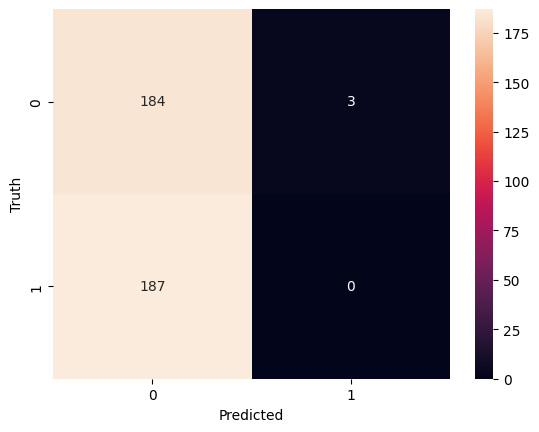

In [61]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

We have to run more epochs to make it more accurate

In [62]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.50      0.98      0.66       187
           1       0.00      0.00      0.00       187

    accuracy                           0.49       374
   macro avg       0.25      0.49      0.33       374
weighted avg       0.25      0.49      0.33       374



In [63]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.27777517],
       [0.3086336 ],
       [0.3045664 ],
       [0.32467288],
       [0.35074055]], dtype=float32)